In [29]:
library(tensorflow)
library(EBImage)
library(XML)
library(stats)
library(RJSONIO)
library(rPython)
#library(leaflet)
#library(htmlwidgets)

python.load("omrekenen.py")

# The aim of this script

We want to determine the location of buoys using a series of gps labeled photos. This will alow us to reconstruct positions of the buoys based on a gps labeled movie.

The aspired application is a system in which cameras on board of ships automatically alarm us, if any buoy has drifted away.

# Data exploration

Let us examine the data that we have at our disposal.

The data consists of two parts. The firt part consists of 5 gps labeled images with a buoy in them. The second part consists of a collection of about 250 photos in which the position of the buoy has been labeled by a bounding box. Hereunder we will plot some of the data in order to get aquinted with it.

In the folder db/test we find the five photos with a buoy in them. The csv file db/test_location gives us the gps locations of these photos. We display the data herunder.

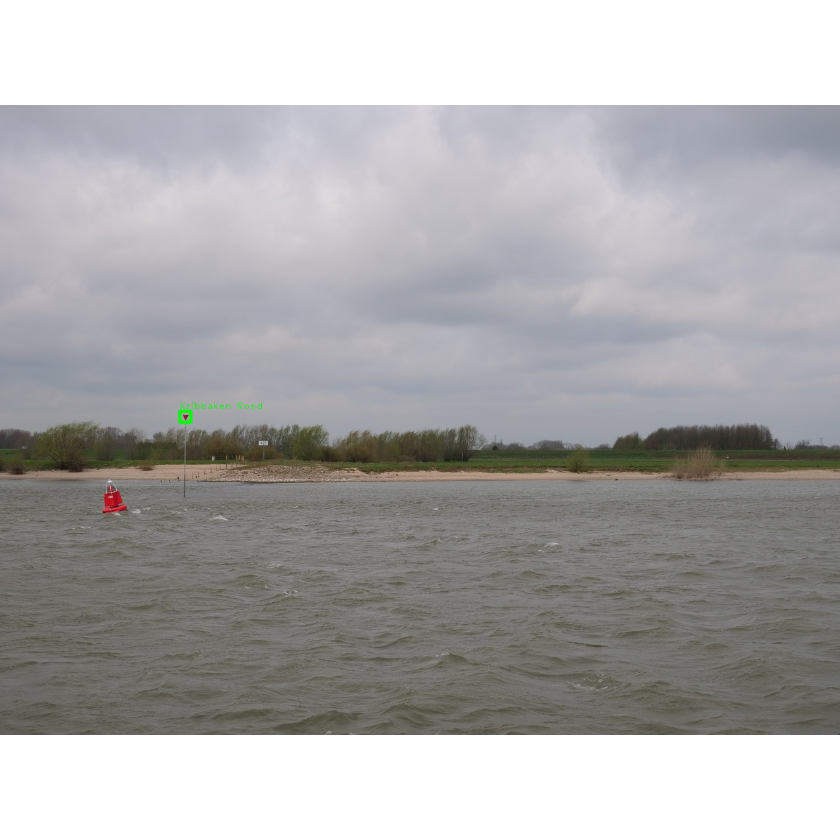

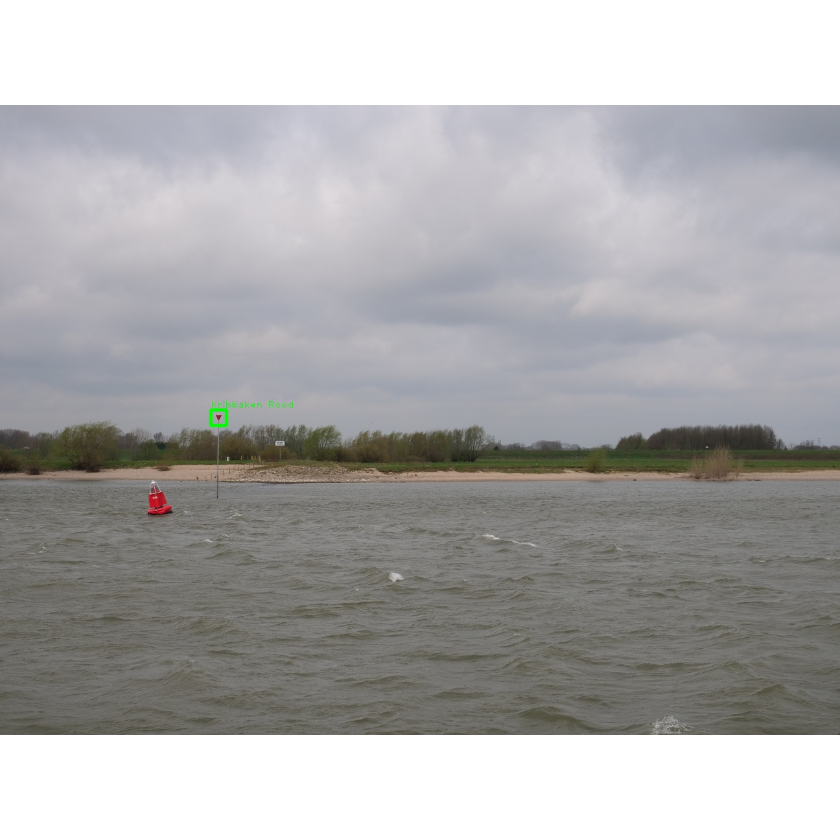

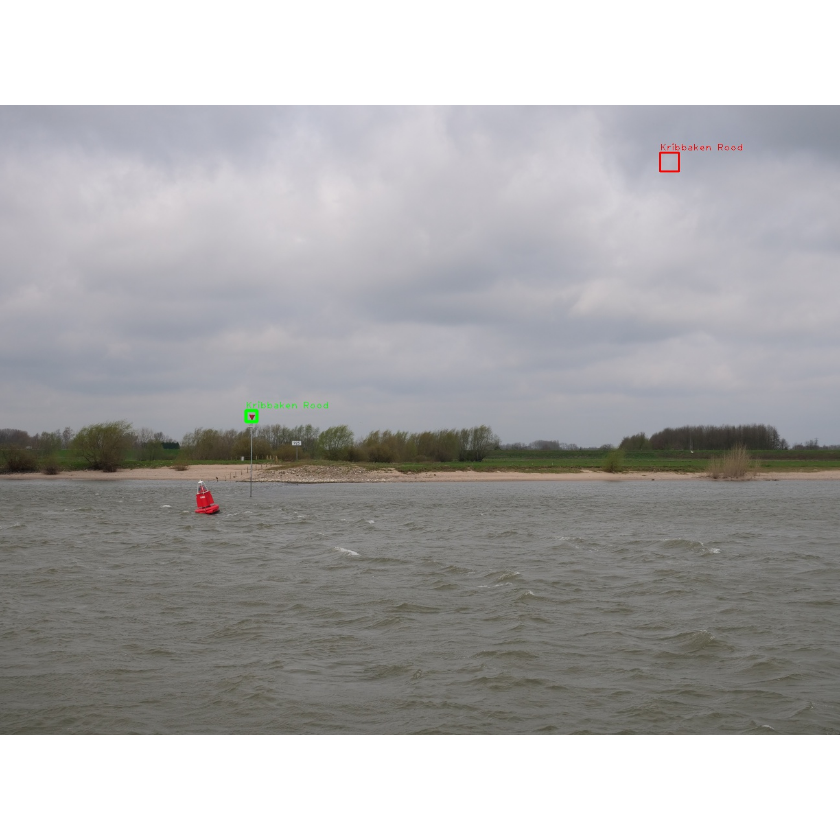

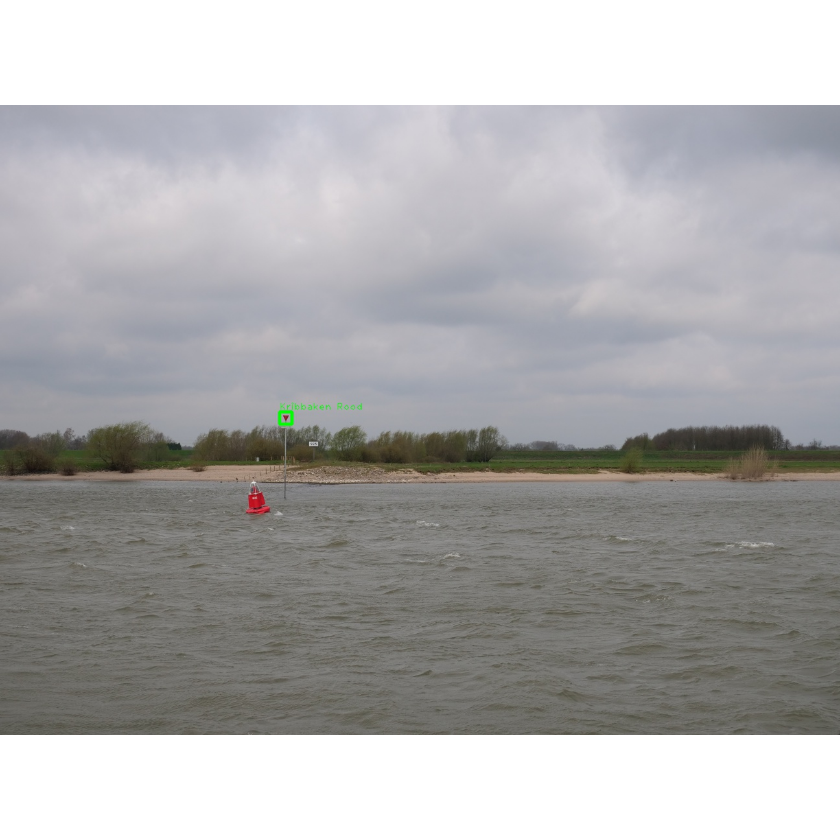

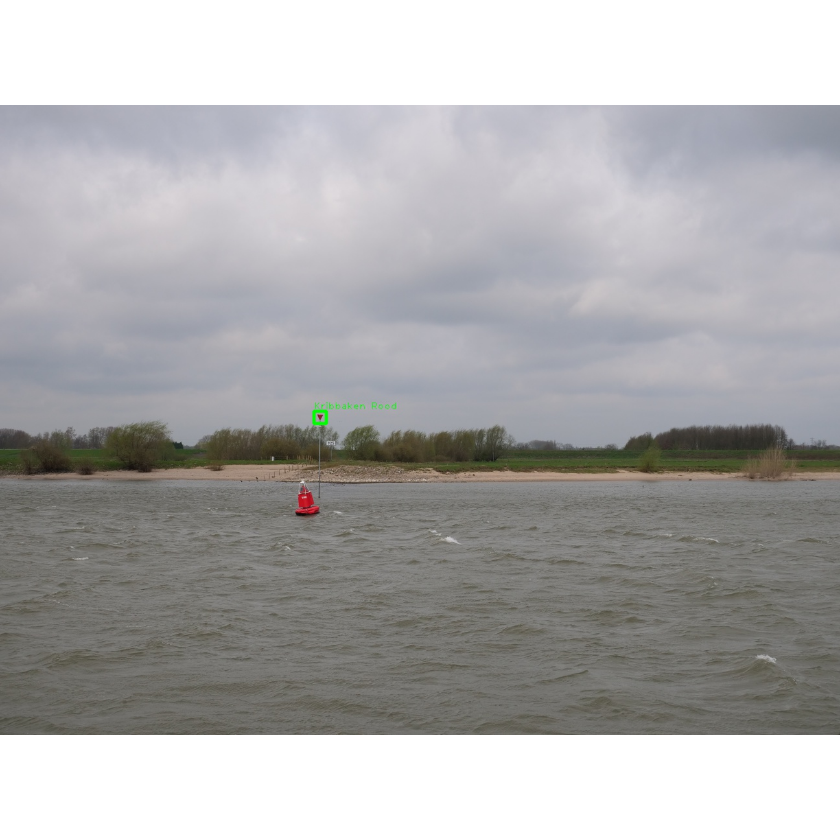

In [30]:
photos = list.files('db/test', full.name = TRUE)
for(im in photos){
im = readImage(im)
display(im)
    }

In [31]:
locations = read.csv('db/test_locations.csv', header = FALSE)
colnames(locations) = c('lat', 'lon')
print(locations)

     lat    lon
1 137007 425083
2 137010 425082
3 137013 425080
4 137016 425077
5 137018 425079


In the folder db/boeien we have a large number of photos of buoys and in train_labels.csv we have a table describing for each filename the bounding box. Let's first have a look at this table.

In [32]:
table = read.csv('db/train_labels.csv')
head(table)

X.1 X  naam                      xmin ymin xmax ymax wx wy
1  1   1 db/boeien/Frame000012.jpg   8  571   51  636  43 65
2  2   2 db/boeien/Frame000013.jpg  82  576  123  630  41 54
3  8   8 db/boeien/Frame000019.jpg 526  580  567  636  41 56
4  9   9 db/boeien/Frame000020.jpg 609  579  644  630  35 51
5 10  10 db/boeien/Frame000021.jpg 684  579  726  637  42 58
6 11  11 db/boeien/Frame000022.jpg 759  580  805  641  46 61

Let's take a random row in this table and display both the coresponding photo and boundbox based on the xmax, ymax, xmin and ymin.

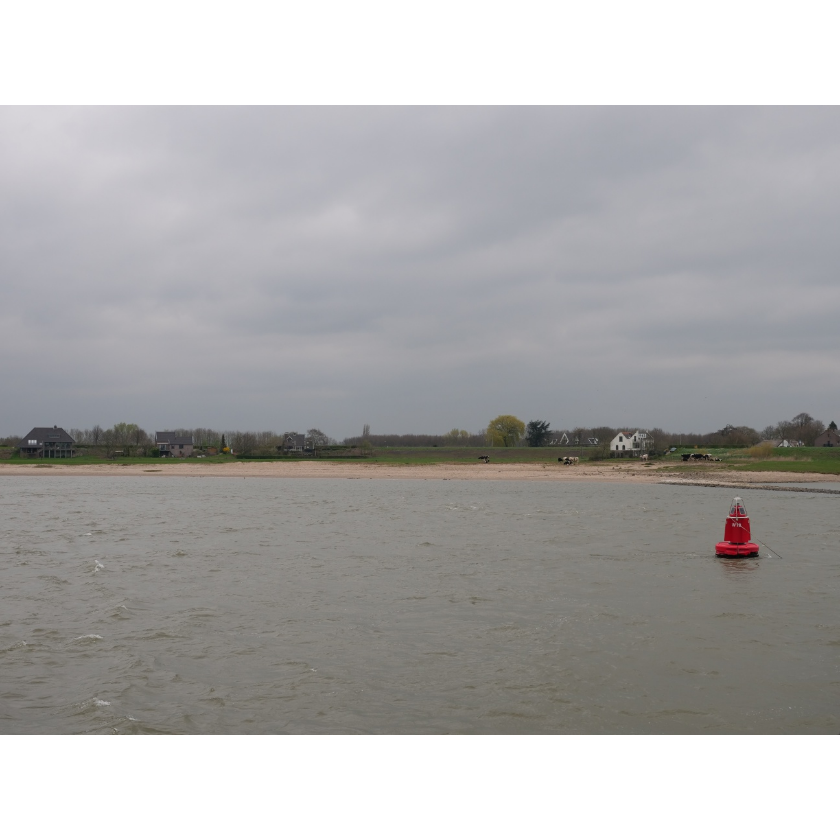

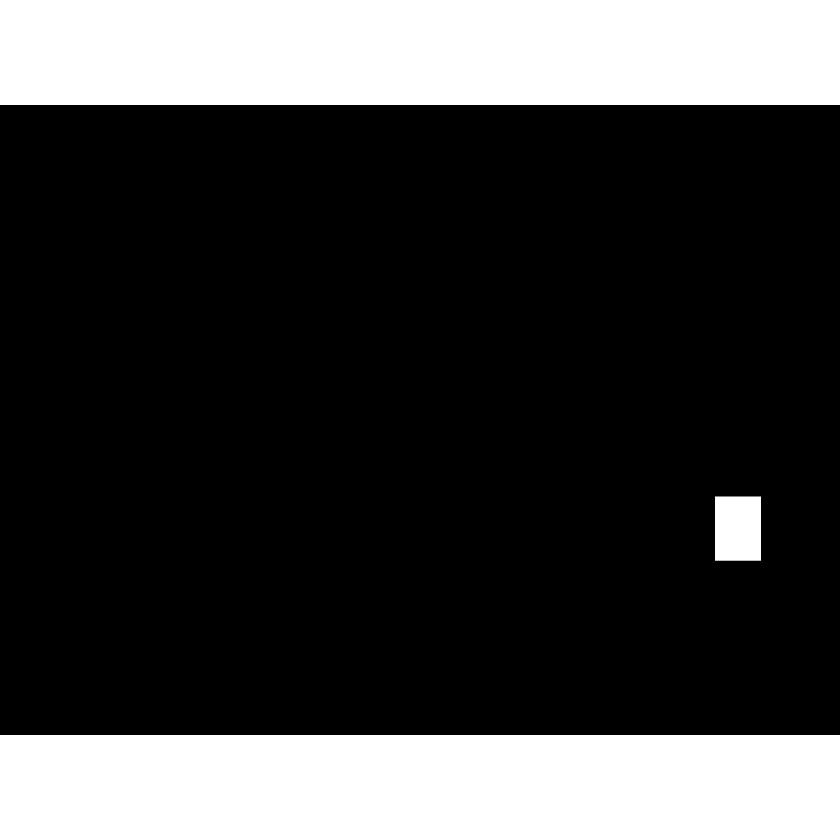

In [33]:
i = sample(x = c(1:nrow(table)), size = 1)
im = table$naam[i]
im = readImage(paste0( im))
display(im)

segmentation = array(0, dim = dim(im)[1:2])
segmentation[table$xmin[i]:table$xmax[i], table$ymin[i]:table$ymax[i]] = 1
display(segmentation)


The bounding boxes seem to have been drawn correctly.

# Per pixel classification

The first task that we want to preform is training a neuralnetwork that determines with what likelyhood a pixel is part of a buoy or not.

Hereunder we define and initialize such a network.

In [75]:
####deze werkt goed
clas = as.integer(2) #aantal klassen
lr = 1e-2 #learningrate
kanalen = as.integer(3) #kanalen image
h= as.integer(972)
w = as.integer(1296)
###############


#############
#place holders
#input
x <- tf$placeholder(tf$float32, shape(NULL, w , h, kanalen))
#target values
label <- tf$placeholder(tf$int32, shape(NULL,w, h))





############variabelen
w_conv1 <-tf$Variable(tf$truncated_normal(shape(4L, 4L, 3L, 8L), stddev=0.1), 'w_conv1')
b_conv1 <- tf$Variable(tf$truncated_normal(shape(1L, 8L), stddev=0.1), 'b_conv1')  
w_conv2 <- tf$Variable(tf$truncated_normal(shape(4L, 4L,   8L, 8L), stddev=0.1), 'w_conv2')
b_conv2 <- tf$Variable(tf$truncated_normal(shape(1L, 8L), stddev=0.1), 'b_conv2')  
w_conv3 <- tf$Variable(tf$truncated_normal(shape(4L, 4L,   8L, 8L), stddev=0.1), 'w_conv3')
b_conv3 <- tf$Variable(tf$truncated_normal(shape(1L, 8L), stddev=0.1), 'b_conv3')  
w_out <- tf$Variable(tf$truncated_normal(shape(1L, 1L,   8L, clas), stddev=0.1), 'w_upconv1')
b_out <- tf$Variable(tf$truncated_normal(shape(1L, clas), stddev=0.1), 'b_upconv1')  
#################


###################### De graph
h_conv1 <- tf$nn$relu(  tf$nn$conv2d(x, w_conv1, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_conv1 )
h_conv2 = tf$nn$relu(  tf$nn$conv2d(h_conv1, w_conv2, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_conv2 )
h_conv3 = tf$nn$relu(  tf$nn$conv2d(h_conv2, w_conv3, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_conv3 )

out =   tf$nn$conv2d(h_conv3, w_out, strides=c(1L, 1L, 1L, 1L), padding='SAME') + b_out 
out_softmax = tf$nn$softmax(out, dim = -1L)
################


################
#fout functie
label_onehot = tf$one_hot(label, depth = clas)
cost  = - tf$reduce_mean(  tf$multiply( label_onehot  ,  tf$log(    tf$clip_by_value(out_softmax, clip_value_min =  1e-10, clip_value_max = 1)   ) ) )

train_step <- tf$train$AdamOptimizer(lr)$minimize(cost)

#####################


###########
#maak sessie
sess <- tf$InteractiveSession()
sess$run(tf$global_variables_initializer())
###############



Now let's train this network.

In [88]:

for (i in 1:5) {
  
  #lees andom plaatjes in
  samp = sample( x=  c(1: nrow(table)) , size = 1 )
  
  print( as.character(table$naam[samp]))
  
im =   readImage( as.character(table$naam[samp]) )
 im = array( im, dim = c(1,dim(im)) )
 
  lab = array(0, dim =  dim(im)[1:3]) 
  lab[1,table$xmin[samp]:table$xmax[samp], table$ymin[samp]:table$ymax[samp]] = 1
 
 
  #train met gradient descent
  train_step$run(feed_dict = dict(x = im , label = lab))
  
 
}



[1] "db/boeien/Frame003079.jpg"
[1] "db/boeien/Frame000268.jpg"
[1] "db/boeien/Frame000675.jpg"
[1] "db/boeien/Frame003801.jpg"
[1] "db/boeien/Frame000357.jpg"


Let's see how the network preforms on our test data.

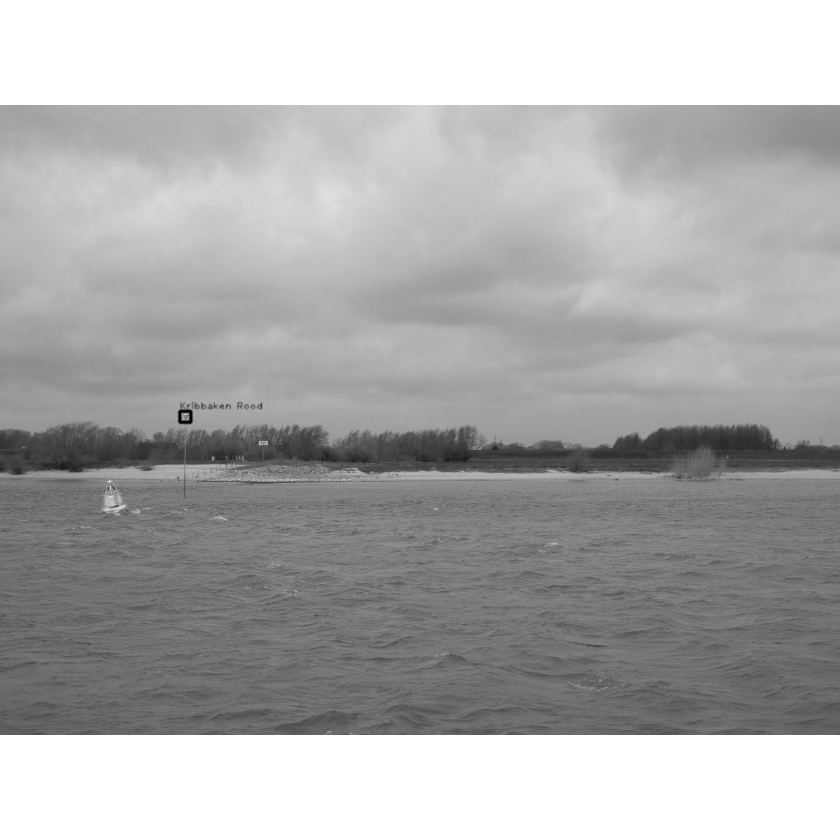

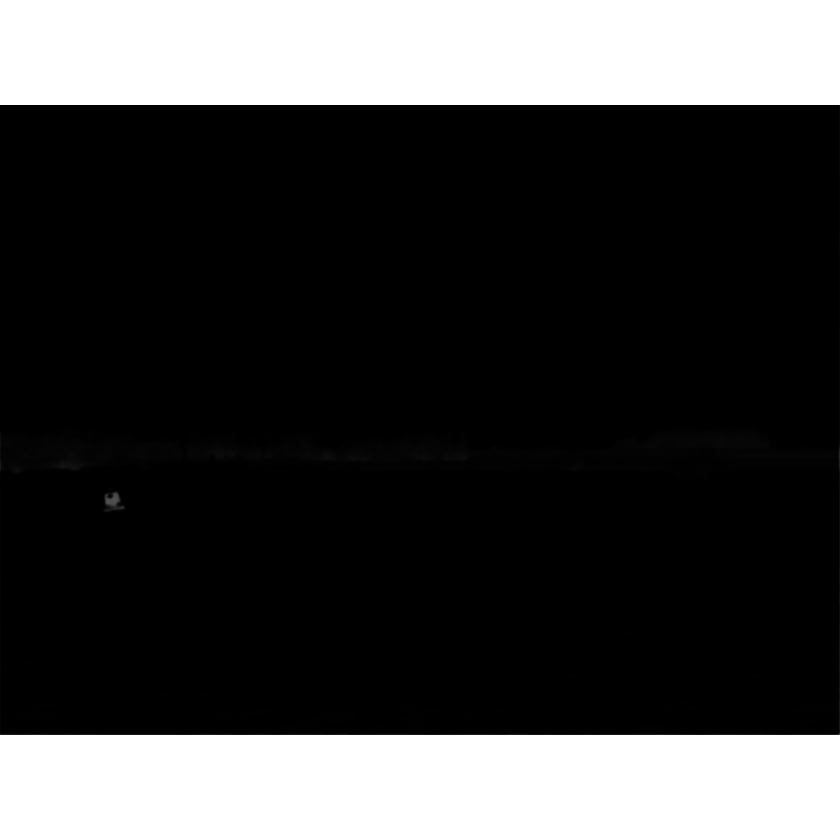

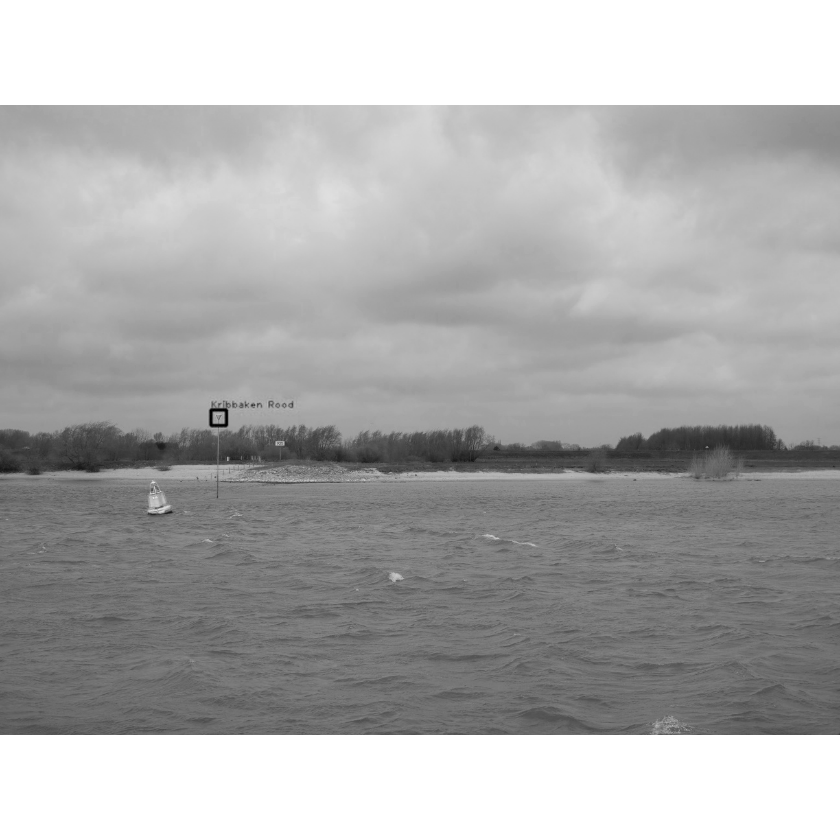

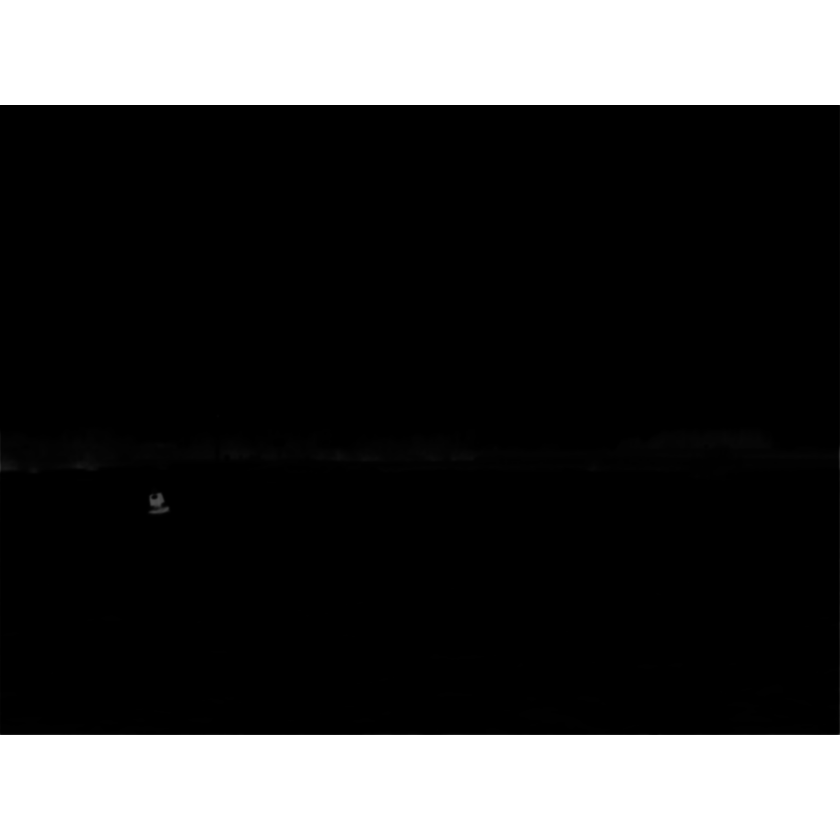

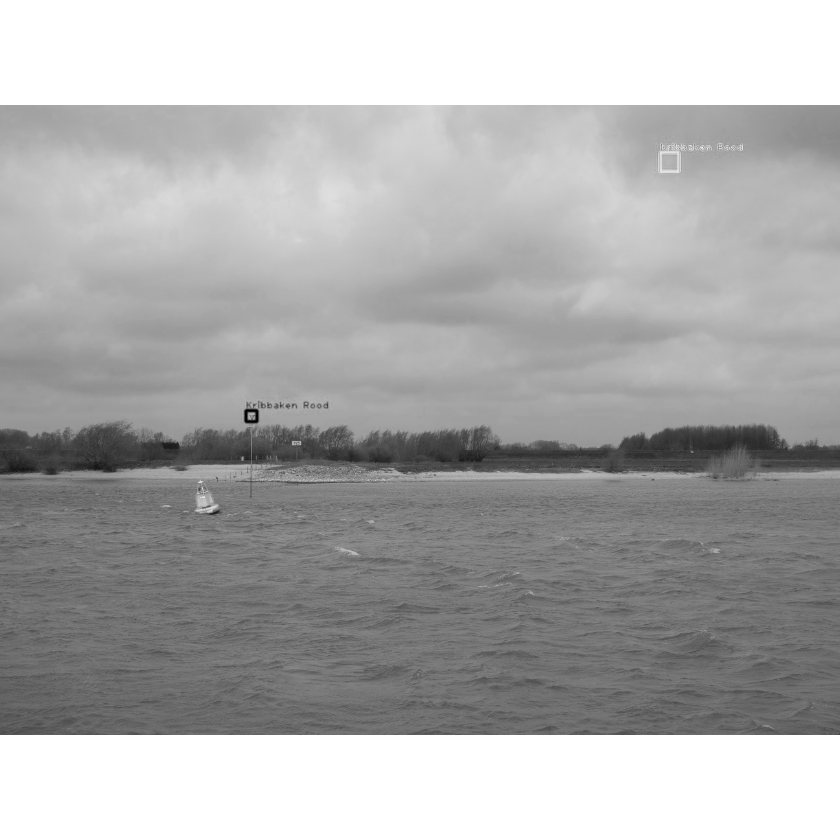

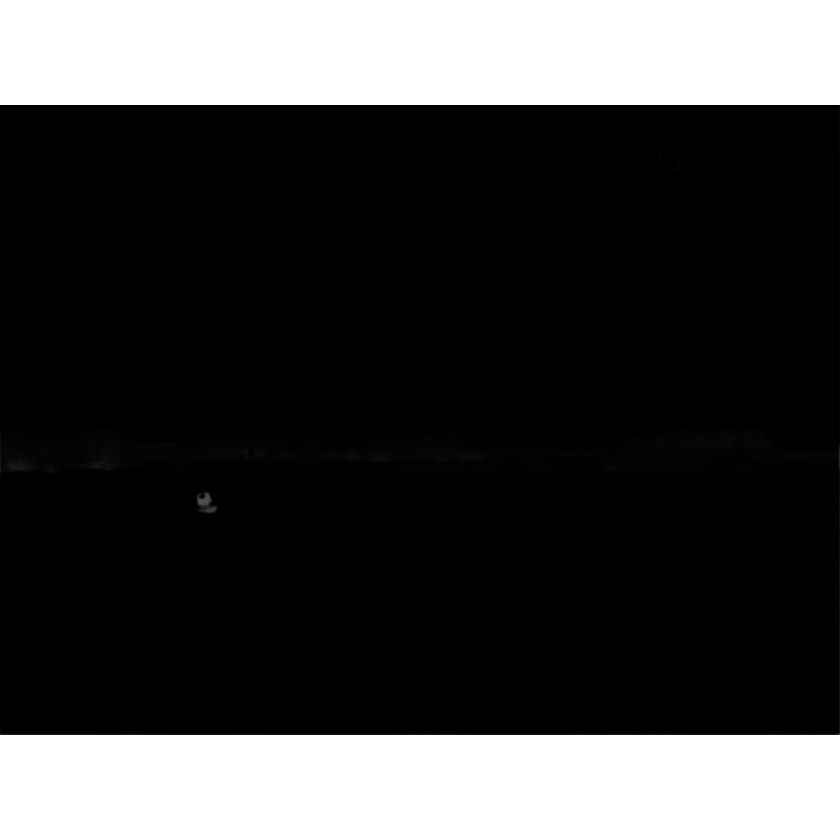

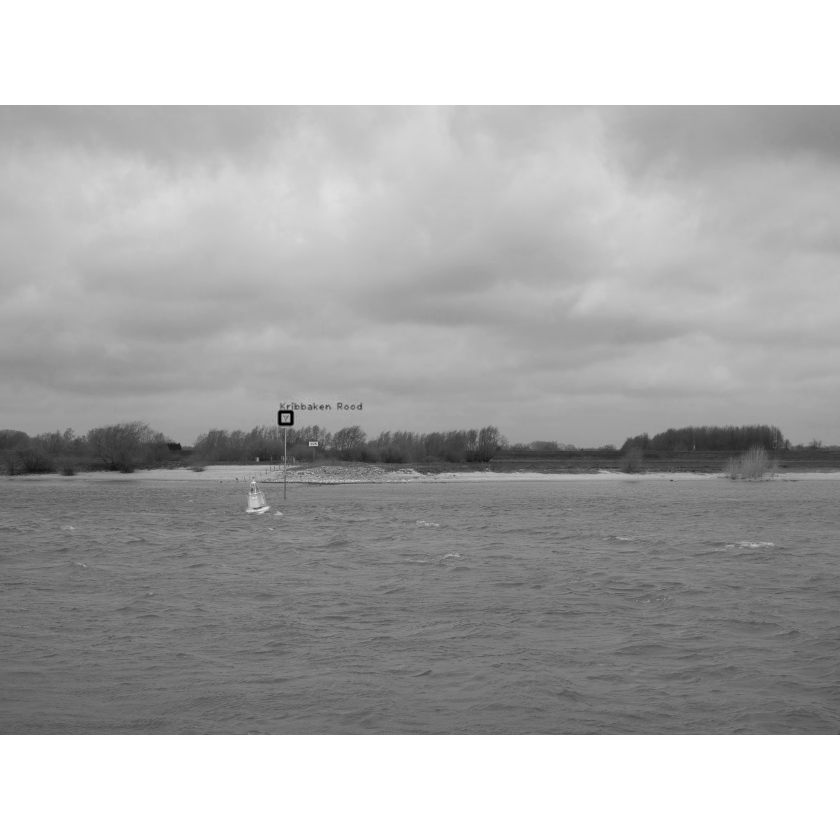

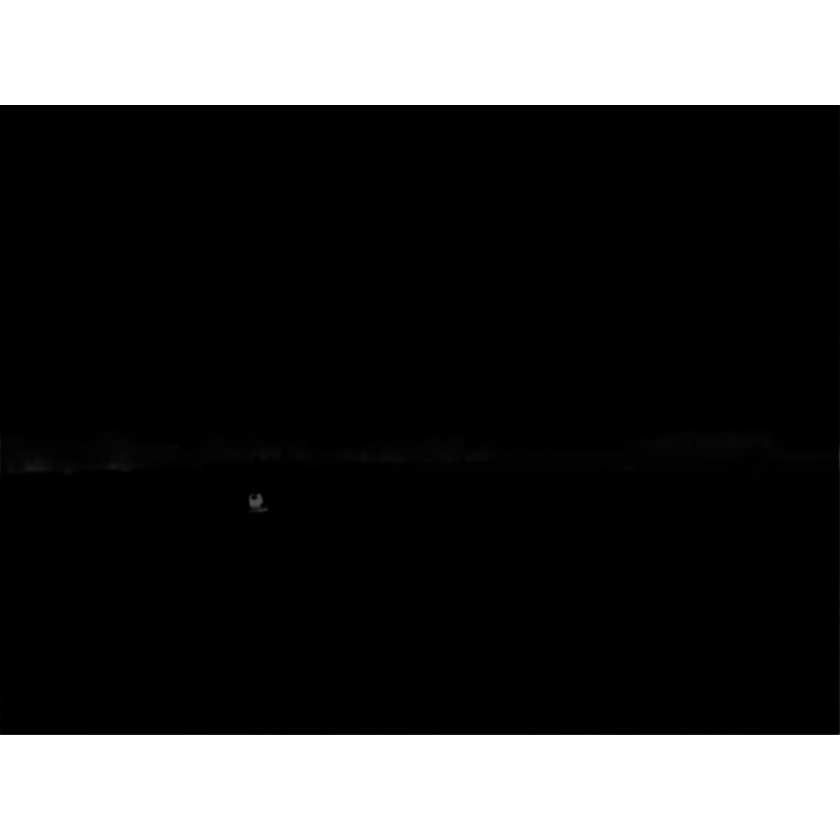

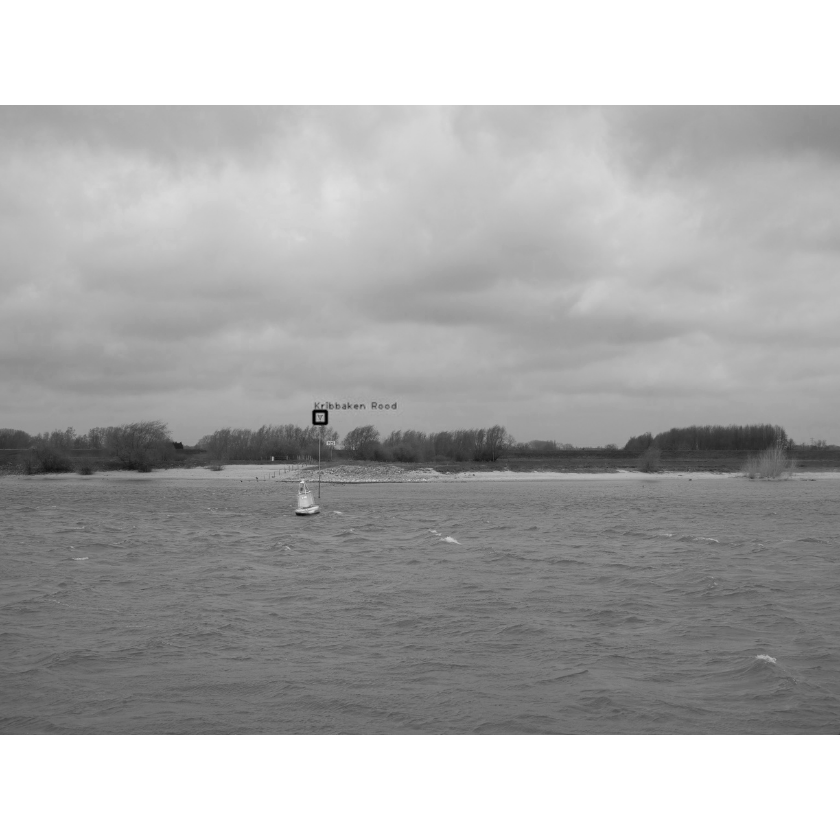

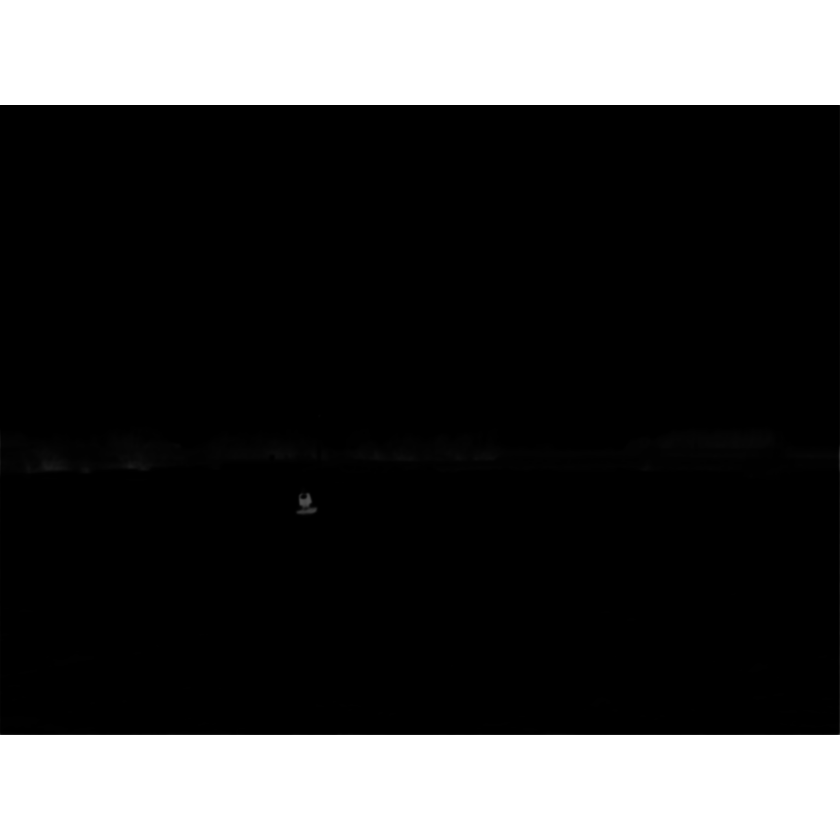

In [89]:
photos = list.files('db/test', full.name = TRUE)
for(im in photos){

im =   readImage( im )
im = array( im, dim = c(1,dim(im)) )

    
output = sess$run(out_softmax, feed_dict = dict(x = im))

display(im[1,,,1])
display(output[1,,,2])
    }

Not too bad.

In case the network performs poorly on the test data, just run the code again. The result is very dependent on the initialization of the weights, which is a stochastic proces.

# Determining the position in the photo

In the previous step we obtained a heatmap in which pixels are brither when the computer deems it likely that the pixel is part of the buoy. However nice it may look it is still not an actual localisation of the buoy in the image. This localisation will be done in this step.

Determining the position of the buoys in the image is done in three steps. Each with using a threshold.

In the firs step we set all pixels to 0 or 1 based on a threshold. In the second step we preform kmeans clustering for k = 1,2,... untill the cost of each cluster is below a certain threshold. In the last step we throw away all clusters containing less pixels than a certain threshold.

We are left with a table listing the location of the buoys in an image.

In [98]:
photos = list.files('db/test', full.name = TRUE)

threshold_pixel = 0.1
threshold_within_ss = 10000000
threshold_cluster_is_buoy = 1200

positions = list()

for( i in 1:length(photos)){
im = photos[i]
  im =   readImage( im )
  im = array( im, dim = c(1,dim(im)) )


  output = sess$run(out_softmax, feed_dict = dict(x = im))
  output = as.matrix(output[1,,,2])
  output = output > threshold_pixel


output_indices = which(output == TRUE , arr.ind = TRUE)

#in case no pixels are switched on we run into an error, therefore add one pixel at 0,0
    output_indices = rbind(output_indices, c(0,0))
    
for(k in 1:100){
     centroids = kmeans( output_indices,k)
       
    if(  max(  centroids$withinss / as.matrix( table(centroids$cluster) )    ) < threshold_within_ss){ break }
}        

    
    is_buoy = as.vector(as.matrix( table(centroids$cluster) ) > threshold_cluster_is_buoy )
    new = as.data.frame( centroids$centers   )  
    new = new[is_buoy,]

    
colnames(new)= c('col', 'row')
positions[[i]] = new 
        



}

print(positions)

[[1]]
       col      row
1 557.5563 865.4774

[[2]]
       col      row
1 561.4499 851.7227

[[3]]
       col      row
1 575.1591 857.1185

[[4]]
       col      row
1 628.7014 873.2397

[[5]]
       col      row
1 621.2678 858.6367



# Calculating the angle with the camera

Using triangle similarity we can, based on the position of the buoy in the photo, calculate the angle the buoy makes with the camera.

We assum that the distance between the film and the lens was 4 cm and the width of the film was 5 cm.

<img src="notebook_images/image.gif">

In [99]:
for( i in 1:length(positions)){
 position_on_film = 5 * (positions[[i]]$col / 1296 - 0.5 )
  positions[[i]]$angle = atan(  position_on_film / 5)  
}

print(positions)

[[1]]
       col      row       angle
1 557.5563 865.4774 -0.06967383

[[2]]
       col      row      angle
1 561.4499 851.7227 -0.0666835

[[3]]
       col      row       angle
1 575.1591 857.1185 -0.05614536

[[4]]
       col      row       angle
1 628.7014 873.2397 -0.01488976

[[5]]
       col      row       angle
1 621.2678 858.6367 -0.02062377



# Calculating the lines on which the buoys lie

Based on the angles with the camera and the gps locations of the photos we can now reconstruct the lines on which the buoys lie.

First we calculate the angle the boat makes with respect to the coordinate system. We add this value to the angle between the buoy and the camera with respect to the coordinate system. We add 0.25 * pi since the camera films perpendicular to the ships movement.

In [100]:
locations_next = rbind(locations, NA)[-1,]
locations_rel = locations_next - locations

locations$angle_boat = tan( locations_rel$lon  / locations_rel$lat )


for( i in 1:length(positions)){
positions[[i]]$absolute_angle =  locations$angle_boat[i] + 0.25 * pi - positions[[i]]$angle 
}

print(positions)

[[1]]
       col      row       angle absolute_angle
1 557.5563 865.4774 -0.06967383      0.5088184

[[2]]
       col      row      angle absolute_angle
1 561.4499 851.7227 -0.0666835     0.06523878

[[3]]
       col      row       angle absolute_angle
1 575.1591 857.1185 -0.05614536     -0.7158642

[[4]]
       col      row       angle absolute_angle
1 628.7014 873.2397 -0.01488976       2.357696

[[5]]
       col      row       angle absolute_angle
1 621.2678 858.6367 -0.02062377             NA



Based on this we can calculate the coefficiet and offset of the line with respect to the coordinate system.

In [101]:
for( i in 1:length(positions)){
    positions[[i]]$coeficient = tan(positions[[i]]$absolute_angle)
    positions[[i]]$offset = locations$lon[i] - positions[[i]]$coeficient * locations$lat[i]

    }


print(positions)

[[1]]
       col      row       angle absolute_angle coeficient   offset
1 557.5563 865.4774 -0.06967383      0.5088184  0.5578085 348659.3

[[2]]
       col      row      angle absolute_angle coeficient   offset
1 561.4499 851.7227 -0.0666835     0.06523878 0.06533149 416130.9

[[3]]
       col      row       angle absolute_angle coeficient   offset
1 575.1591 857.1185 -0.05614536     -0.7158642  -0.869777 544250.8

[[4]]
       col      row       angle absolute_angle coeficient   offset
1 628.7014 873.2397 -0.01488976       2.357696 -0.9970022 561682.3

[[5]]
       col      row       angle absolute_angle coeficient offset
1 621.2678 858.6367 -0.02062377             NA         NA     NA



# Calculating the position of the buoy

The buoy lies on the intersection of these lines. We calculate the intersection of the first two photos.

In [102]:
n = 1
m= 2

x_intersect = (positions[[n]]$offset[1] - positions[[m]]$offset[1]) / (positions[[m]]$coeficient[1] - positions[[n]]$coeficient[1])
y_intersect  =   positions[[n]]$coeficient[1] * x_intersect +   positions[[n]]$offset[1] 

print( paste('x_intersect:', x_intersect , 'y_intersect:' , y_intersect))

[1] "x_intersect: 137004.571471447 y_intersect: 425081.645346137"


# Plot positions on a leaflet

We calculate the position in wgs coordinates and plot it in a leaflet.

In [103]:
coords = c(x_intersect, y_intersect)
python.assign('RDCoords', coords)
python.exec('coords = conv.fromRdToWgs( RDCoords )')
coords = python.get('coords')

print(coords)

[1] 51.814053  5.126171


In [104]:
#m = leaflet()
#m = addTiles(m)
#m = addMarkers(m, lng= coords[2], lat= coords[1])
#m =  addProviderTiles(m,providers$OpenStreetMap)

#saveWidget(m, file="buoy_location.html")